In [1]:
import glob
import math
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import torch
from torch.optim import Adam, SGD
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import (
    CacheDataset,
    DataLoader,
    ThreadDataLoader,
    Dataset,
    decollate_batch,
    set_track_meta,
)
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.layers import Act, Norm
from monai.networks.nets import UNet, SwinUNETR, AHNet, VNet

from monai.transforms import (
    EnsureChannelFirstd,
    AsDiscrete,
    Compose,
    CropForegroundd,
    EnsureTyped,
    FgBgToIndicesd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
)
from monai.utils import set_determinism


from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"  # Use the 3rd and 4th GPU. Indexing starts from 0.

# for profiling
import nvtx
from monai.utils.nvtx import Range
import contextlib  # to improve code readability (combining training/validation loop with and without profiling)

#print_config()
set_determinism(0)

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"root dir is: {root_dir}")

current_directory = os.getcwd()

out_dir = os.path.join(current_directory,"outputs/")

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

root dir is: /tmp/tmp7eg2dv6s


In [3]:
profiling = True

# to see the trend in training curve and dice results, set max_epochs to be larger (300)
# note that before optimization, training can be quite a bit slower
if profiling:
    max_epochs = 1000
else:
    max_epochs = 400

def range_func(x, y):
    return Range(x)(y) if profiling else y


no_profiling = contextlib.nullcontext()

In [4]:
# import nibabel as nib
# from tqdm import tqdm
# # Define the directories
# volume_dir = os.path.join(current_directory, 'train_seg')
# segmentation_alt_dir = os.path.join(current_directory, 'segmentations_alt')

# # List the files in each directory
# volume_files = sorted([f for f in os.listdir(volume_dir) if f.endswith('.nii.gz')])
# segmentation_alt_files = sorted([f for f in os.listdir(segmentation_alt_dir) if f.endswith('.nii')])

# bad_cases = []
# shapes = []
# for i in tqdm(range(len(volume_files))):
#     vol_file = volume_files[i]
#     seg_file = segmentation_alt_files[i]
    
#     volume_path = os.path.join(volume_dir, vol_file)
    
#     segmentation_alt_path = os.path.join(segmentation_alt_dir, seg_file)
    
#     volume_nii = nib.load(volume_path)
#     segmentation_alt_nii = nib.load(segmentation_alt_path)
    
#     volume_data = volume_nii.get_fdata()
#     segmentation_alt_data = segmentation_alt_nii.get_fdata()
    
#     if volume_data.shape!=segmentation_alt_data.shape:
#         bad_cases.append(i)
#     elif volume_data.shape[0]<190 or volume_data.shape[1]<190 or volume_data.shape[2]<190:
#         bad_cases.append(i)

#     shapes.append(volume_data.shape)

In [5]:
# import os
# import json
# import numpy as np

# SEGMENTATION_CODES = {
#     0: 'background',
#     1: 'liver',
#     2: 'spleen',
#     3: 'kidney_left',
#     4: 'kidney_right',
#     5: 'bowel',
# }

# def create_json_file(current_directory, output_file):
#     # Define the directories
#     volume_dir = os.path.join(current_directory, 'train_seg')
#     segmentation_alt_dir = os.path.join(current_directory, 'segmentations_alt')
    
#     # List the files in each directory
#     volume_files = sorted([f for f in os.listdir(volume_dir) if f.endswith('.nii.gz')])
#     segmentation_alt_files = sorted([f for f in os.listdir(segmentation_alt_dir) if f.endswith('.nii')])

#     volume_files = [value for index, value in enumerate(volume_files) if index not in bad_cases]
#     segmentation_alt_files = [value for index, value in enumerate(segmentation_alt_files) if index not in bad_cases]

#     # Randomly select 100 samples
#     selected_indices = np.random.choice(len(volume_files), 60, replace=False)
    
#     volume_files = [volume_files[i] for i in selected_indices]
#     segmentation_alt_files = [segmentation_alt_files[i] for i in selected_indices]

#     # Determine the split ratio dynamically
#     total_files = len(volume_files)
#     num_train = int(total_files * 0.7)
#     num_valid = int(total_files * 0.2)
#     num_test = total_files - num_train - num_valid
    
#     # Generate random indices
#     indices = np.arange(total_files)
#     np.random.shuffle(indices)
    
#     # Construct training, validation, and test lists
#     training = [{"image": f"train_seg/{volume_files[i]}", "label": f"segmentations_alt/{segmentation_alt_files[i]}"} for i in indices[:num_train]]
#     validation = [{"image": f"train_seg/{volume_files[i]}", "label": f"segmentations_alt/{segmentation_alt_files[i]}"} for i in indices[num_train:num_train+num_valid]]
#     test = [{"image": f"train_seg/{volume_files[i]}", "label": f"segmentations_alt/{segmentation_alt_files[i]}"} for i in indices[num_train+num_valid:]]
    
#     # Construct the JSON structure
#     data = {
#         "description": "btcv yucheng",
#         "labels": {
#             "0": "background",
#             **{str(k): v for k, v in SEGMENTATION_CODES.items()}
#         },
#         "licence": "yt",
#         "modality": {
#             "0": "CT"
#         },
#         "name": "atd",
#         "numTest": num_test,
#         "numTraining": num_train,
#         "reference": "Tyrell To",
#         "release": "No Date",
#         "tensorImageSize": "3D",
#         "test": test,
#         "training": training,
#         "validation": validation
#     }
    
#     # Save to JSON file
#     with open(output_file, 'w') as json_file:
#         json.dump(data, json_file, indent=4)

# # Get the current working directory
# current_directory = "/workspace/0728tot/ATD/"

# create_json_file(current_directory, 'output_2.json')


In [5]:
import os
import pandas as pd
from tqdm import tqdm
from monai.data import Dataset
from torch.utils.data import DataLoader

current_directory = "/workspace/0728tot/ATD/"


split_json = "output_2.json"

datasets = os.path.join(current_directory, split_json)
train_files = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")

# train_ds = Dataset(data=train_files, transform=train_transforms)
# train_loader = DataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)

# val_ds = Dataset(data=val_files, transform=val_transforms)
# val_loader = DataLoader(val_ds, num_workers=0, batch_size=1)

def transformations(fast=False, device="cuda:0"):
    train_transforms = [
        range_func("LoadImage", LoadImaged(keys=["image", "label"])),
        range_func("EnsureChannelFirst", EnsureChannelFirstd(keys=["image", "label"])),
        range_func("Orientation", Orientationd(keys=["image", "label"], axcodes="RAS")),
        range_func(
            "Spacing",
            Spacingd(
                keys=["image", "label"],
                pixdim=(2.0, 2.0, 2.0),
                mode=("bilinear", "nearest"),
            ),
        ),
        range_func(
            "ScaleIntensityRange",
            ScaleIntensityRanged(
                keys=["image"],
                a_min=-57,
                a_max=164,
                b_min=0.0,
                b_max=1.0,
                clip=True,
            ),
        ),
        #range_func("CropForeground", CropForegroundd(keys=["image", "label"], source_key="image")),
        #range_func("DynamicAxisPad", DynamicAxisPad(keys=['image'], desired_size=96, mode='constant')),
        # range_func(
        #     "Indexing",
        #     FgBgToIndicesd(
        #         keys="label",
        #         fg_postfix="_fg",
        #         bg_postfix="_bg",
        #         image_key="image",
        #     ),
        # ),
    ]

    if fast:
        # convert the data to Tensor without meta, move to GPU and cache to avoid CPU -> GPU sync in every epoch
        train_transforms.append(
            range_func("EnsureType", EnsureTyped(keys=["image", "label"], device=device, track_meta=False))
        )

    train_transforms.append(
        # randomly crop out patch samples from big
        # image based on pos / neg ratio
        # the image centers of negative samples
        # must be in valid image area
        range_func(
            "RandCrop",
            RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=(96, 96, 96),
                pos=1,
                neg=1,
                num_samples=3,
                fg_indices_key="label_fg",
                bg_indices_key="label_bg",
            ),
        ),
    )

    val_transforms = [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(2.0, 2.0, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
    if fast:
        # convert the data to Tensor without meta, move to GPU and cache to avoid CPU -> GPU sync in every epoch
        val_transforms.append(EnsureTyped(keys=["image", "label"], device=device, track_meta=False))

    return Compose(train_transforms), Compose(val_transforms)

In [7]:
def train_process(fast=False):
    learning_rate = 2e-4
    val_interval = 5  # do validation for every epoch
    set_track_meta(True)

    if torch.cuda.is_available():
        data_device = torch.device("cuda:0")
    else:
        raise RuntimeError("this tutorial is intended for GPU, but no CUDA device is available")

    train_trans, val_trans = transformations(fast=fast, device=data_device)
    # set CacheDataset, ThreadDataLoader and DiceCE loss for MONAI fast training
    if fast:
        # as `RandCropByPosNegLabeld` crops from the cached content and `deepcopy`
        # the crop area instead of modifying the cached value, we can set `copy_cache=False`
        # to avoid unnecessary deepcopy of cached content in `CacheDataset`
        train_ds = CacheDataset(
            data=train_files,
            transform=train_trans,
            cache_rate=1.0,
            num_workers=8,
            copy_cache=False,
        )
        val_ds = CacheDataset(data=val_files, transform=val_trans,cache_rate=1.0, num_workers=5, copy_cache=False)
        # disable multi-workers because `ThreadDataLoader` works with multi-threads
        train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=4, shuffle=True)
        val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)
        
        model_device = torch.device("cuda:1")
        
        loss_function = DiceCELoss(
            include_background=False,
            to_onehot_y=True,
            softmax=True,
            squared_pred=True,
            batch=True,
            smooth_nr=0.00001,
            smooth_dr=0.00001,
            lambda_dice=0.5,
            lambda_ce=0.5,
        )
        
        model = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=6,
            channels=(32, 64, 128, 256, 512),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            norm=Norm.BATCH,
            kernel_size=3,
            up_kernel_size=3,
            act=Act.PRELU,
            dropout=0.2,
            bias=True,
        ).to(model_device)

        # avoid the computation of meta information in random transforms
        set_track_meta(False)
    else:
        train_ds = Dataset(data=train_files, transform=train_trans)
        val_ds = Dataset(data=val_files, transform=val_trans)
        train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=8)
        val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)
        loss_function = DiceLoss(to_onehot_y=True, softmax=True)
        model = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=6,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            norm=Norm.BATCH,
        ).to(model_device)

    post_pred = Compose([AsDiscrete(argmax=True, to_onehot=6)])
    post_label = Compose([AsDiscrete(to_onehot=6)])

    dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

    if fast:
        # SGD prefer to much bigger learning rate
        optimizer = SGD(
            model.parameters(),
            lr=learning_rate * 1000,
            momentum=0.9,
            weight_decay=0.00004,
        )
        scaler = torch.cuda.amp.GradScaler()
    else:
        optimizer = Adam(model.parameters(), learning_rate)

    best_metric = -1
    best_metric_epoch = -1
    best_metrics_epochs_and_time = [[], [], []]
    epoch_loss_values = []
    metric_values = []
    epoch_times = []
    total_start = time.time()

    for epoch in range(max_epochs):
        epoch_start = time.time()
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")

        # profiling: full epoch
        with nvtx.annotate("epoch", color="red") if profiling else no_profiling:
            model.train()
            epoch_loss = 0
            train_loader_iterator = iter(train_loader)

            # using step instead of iterate through train_loader directly to track data loading time
            # steps are 1-indexed for printing and calculation purposes
            for step in range(1, len(train_loader) + 1):
                step_start = time.time()

                # profiling: train dataload
                with nvtx.annotate("dataload", color="red") if profiling else no_profiling:
                    # rng_train_dataload = nvtx.start_range(message="dataload", color="red")
                    batch_data = next(train_loader_iterator)
                    inputs, labels = (
                        batch_data["image"].to(model_device),
                        batch_data["label"].to(model_device),
                    )

                optimizer.zero_grad()
                # set AMP for MONAI training
                if fast:
                    # profiling: forward
                    with nvtx.annotate("forward", color="green") if profiling else no_profiling:
                        with torch.cuda.amp.autocast():
                            outputs = model(inputs)
                            loss = loss_function(outputs, labels)

                    # profiling: backward
                    with nvtx.annotate("backward", color="blue") if profiling else no_profiling:
                        scaler.scale(loss).backward()

                    # profiling: update
                    with nvtx.annotate("update", color="yellow") if profiling else no_profiling:
                        scaler.step(optimizer)
                        scaler.update()
                else:
                    # profiling: forward
                    with nvtx.annotate("forward", color="green") if profiling else no_profiling:
                        outputs = model(inputs)
                        loss = loss_function(outputs, labels)

                    # profiling: backward
                    with nvtx.annotate("backward", color="blue") if profiling else no_profiling:
                        loss.backward()

                    # profiling: update
                    with nvtx.annotate("update", color="yellow") if profiling else no_profiling:
                        optimizer.step()

                epoch_loss += loss.item()
                epoch_len = math.ceil(len(train_ds) / train_loader.batch_size)
                print(
                    f"{step}/{epoch_len}, train_loss: {loss.item():.4f}" f" step time: {(time.time() - step_start):.4f}"
                )
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

            if (epoch + 1) % val_interval == 0:
                model.eval()
                with torch.no_grad():
                    val_loader_iterator = iter(val_loader)

                    for _ in range(len(val_loader)):
                        # profiling: val dataload
                        with nvtx.annotate("dataload", color="red") if profiling else no_profiling:
                            val_data = next(val_loader_iterator)
                            val_inputs, val_labels = (
                                val_data["image"].to(model_device),
                                val_data["label"].to(model_device),
                            )

                        roi_size = (96, 96, 96)
                        sw_batch_size = 4

                        # profiling: sliding window
                        with nvtx.annotate("sliding window", color="green") if profiling else no_profiling:
                            # set AMP for MONAI validation
                            if fast:
                                with torch.cuda.amp.autocast():
                                    val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                            else:
                                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)

                        # profiling: decollate batch
                        with nvtx.annotate("decollate batch", color="blue") if profiling else no_profiling:
                            val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                            val_labels = [post_label(i) for i in decollate_batch(val_labels)]

                        # profiling: compute metric
                        with nvtx.annotate("compute metric", color="yellow") if profiling else no_profiling:
                            dice_metric(y_pred=val_outputs, y=val_labels)

                    metric = dice_metric.aggregate().item()
                    dice_metric.reset()
                    metric_values.append(metric)
                    if metric > best_metric:
                        best_metric = metric
                        best_metric_epoch = epoch + 1
                        best_metrics_epochs_and_time[0].append(best_metric)
                        best_metrics_epochs_and_time[1].append(best_metric_epoch)
                        best_metrics_epochs_and_time[2].append(time.time() - total_start)
                        torch.save(model.state_dict(), os.path.join(current_directory, "unet_best_metric_model.pt"))
                        print("saved new best metric model")
                    print(
                        f"current epoch: {epoch + 1} current"
                        f" mean dice: {metric:.4f}"
                        f" best mean dice: {best_metric:.4f}"
                        f" at epoch: {best_metric_epoch}"
                    )
        print(f"time consuming of epoch {epoch + 1} is:" f" {(time.time() - epoch_start):.4f}")
        epoch_times.append(time.time() - epoch_start)

    total_time = time.time() - total_start
    print(
        f"train completed, best_metric: {best_metric:.4f}"
        f" at epoch: {best_metric_epoch}"
        f" total time: {total_time:.4f}"
    )
    return (
        max_epochs,
        epoch_loss_values,
        metric_values,
        epoch_times,
        best_metrics_epochs_and_time,
        total_time,
    )

In [8]:
set_determinism(seed=0)
monai_start = time.time()
(
    epoch_num,
    m_epoch_loss_values,
    m_metric_values,
    m_epoch_times,
    m_best,
    m_train_time,
) = train_process(fast=True)
m_total_time = time.time() - monai_start
print(
    f"total time of {epoch_num} epochs with MONAI fast training: {m_train_time:.4f},"
    f" time of preparing cache: {(m_total_time - m_train_time):.4f}"
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
Loading dataset: 100%|███████████████████████████████████| 12/12 [00:23<00:00,  1.92s/it]


----------
epoch 1/1000
1/11, train_loss: 1.5232 step time: 1.1774
2/11, train_loss: 1.2089 step time: 0.2028
3/11, train_loss: 0.8188 step time: 0.2259
4/11, train_loss: 0.7552 step time: 0.2987
5/11, train_loss: 0.9293 step time: 0.2553
6/11, train_loss: 0.7593 step time: 0.2787
7/11, train_loss: 0.7728 step time: 0.3242
8/11, train_loss: 0.6741 step time: 0.2761
9/11, train_loss: 0.6165 step time: 0.2893
10/11, train_loss: 0.8665 step time: 0.3225
11/11, train_loss: 0.7217 step time: 0.1495
epoch 1 average loss: 0.8769
time consuming of epoch 1 is: 3.8024
----------
epoch 2/1000
1/11, train_loss: 0.6805 step time: 0.3400
2/11, train_loss: 0.7791 step time: 0.3045
3/11, train_loss: 0.6424 step time: 0.2861
4/11, train_loss: 0.7180 step time: 0.2817
5/11, train_loss: 1.0617 step time: 0.3308
6/11, train_loss: 0.6181 step time: 0.2814
7/11, train_loss: 0.6618 step time: 0.2772
8/11, train_loss: 0.6324 step time: 0.2589
9/11, train_loss: 0.6598 step time: 0.3170
10/11, train_loss: 0.674

In [6]:
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)

In [7]:
test_files = load_decathlon_datalist(datasets, True, "validation")

In [8]:
test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(2.0, 2.0, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

test_org_ds = Dataset(data=test_files, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=0)

# post_transforms = Compose(
#     [
#         Invertd(
#             keys="pred",
#             transform=test_org_transforms,
#             orig_keys="image",
#             meta_keys="pred_meta_dict",
#             orig_meta_keys="image_meta_dict",
#             meta_key_postfix="meta_dict",
#             nearest_interp=False,
#             to_tensor=True,
#         ),
#         AsDiscreted(keys="pred", argmax=True, to_onehot=6),
#         SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir=os.path.join(current_directory, "unet_results"), output_postfix="seg", resample=False),
#     ]
# )

# post_transforms = Compose(
#     [
#         Invertd(
#             keys="pred",
#             transform=test_org_transforms,
#             orig_keys="image",
#             meta_keys="pred_meta_dict",
#             orig_meta_keys="image_meta_dict",
#             meta_key_postfix="meta_dict",
#             nearest_interp=False,
#             to_tensor=True,
#             device="cpu",
#         ),
#         AsDiscreted(keys="pred", argmax=True, to_onehot=6),
#         AsDiscreted(keys="label", to_onehot=6),
#     ]
# )

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.3.


In [9]:
from monai.transforms import LoadImage
loader = LoadImage()

monai.transforms.io.array LoadImage.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [9]:
model_device = torch.device("cuda:1")

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=6,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
    kernel_size=3,
    up_kernel_size=3,
    act=Act.PRELU,
    dropout=0.2,
    bias=True,
).to(model_device)

model.load_state_dict(torch.load(os.path.join(current_directory, "unet_best_metric_model.pt")))
model.eval()


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.2, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.2, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [10]:
curr_data = None
with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(model_device)
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        curr_data =  sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)
        # test_data = [post_transforms(i) for i in decollate_batch(test_data)]

# #         # uncomment the following lines to visualize the predicted results
#         test_output = from_engine(["pred"])(test_data)

#         original_image = loader(test_output[0].meta["filename_or_obj"])

#         plt.figure("check", (18, 6))
#         plt.subplot(1, 2, 1)
#         plt.imshow(original_image[:, :, 20], cmap="gray")
#         plt.subplot(1, 2, 2)
#         plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
#         plt.show()
        break

In [115]:
ideal_size = list(test_data['image_meta_dict']['spatial_shape'][0].cpu().detach().numpy())

In [116]:
import torch.nn.functional as F

# Move curr_data to CPU
segmented = curr_data.cpu()

# Upsample the tensor to target shape
upsampled = F.interpolate(segmented, size=ideal_size, mode='trilinear', align_corners=True)

# Convert to binary masks by thresholding
#upsampled = (upsampled > 0.5).float()

# Merge the masks with numbers (1 to 6)
merged = torch.argmax(upsampled, dim=1) + 1  # add 1 to move the range from 0-5 to 1-6

# Ensure background remains 0
merged[upsampled.sum(dim=1) == 0] = 0

# Reshape the merged tensor
merged_resized = merged.squeeze(0)

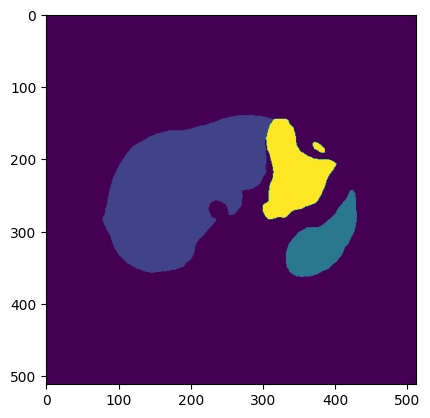

In [89]:
plt.imshow(merged[0][200])

In [22]:
import gc
gc.collect()
torch.cuda.empty_cache()
